<a href="https://colab.research.google.com/github/sleepymor/Week-4-Introduction-to-AI/blob/main/P5_2_traveling_salesman_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$.

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  >
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# make the results repeatable
np.random.seed(1234)

In [22]:
def random_tour(n):
    """Create a random tour"""

    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[3, 2, 8, 9, 4, 1, 5, 7, 6, 0]

In [23]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a
    pairwise Euclidean distance matrix.
    """

    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })

    dist = squareform(pdist(pos))

    return({"pos": pos, "dist": dist})

tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [24]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""

    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()

    tl = 0
    dist = tsp["dist"]

    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]

    tl += dist[tour[-1], tour[0]]

    return(tl)

tour = random_tour(10)
tour_length(tsp, tour)

np.float64(4.8849325058124435)

Tour length: 4.88


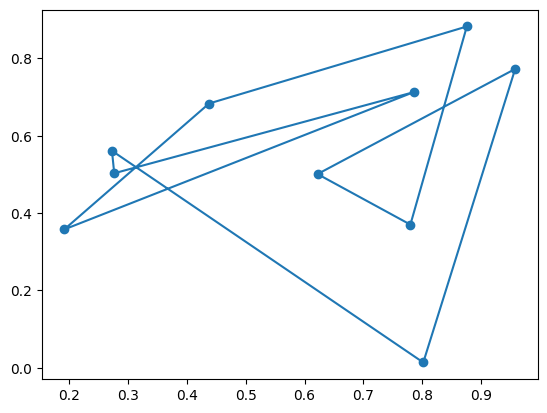

In [25]:
def show_tsp(tsp, tour = None):
    """display the traveling salesman problem and a tour."""

    pos = tsp["pos"]

    plt.scatter(pos["x"], pos["y"])

    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()

        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")

        pos_ = pos.reindex(tour)
        pos_ = pd.concat([pos_, pos_.head(1)])
        plt.plot(pos_["x"], pos_["y"])

    plt.show()

show_tsp(tsp, tour)

## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [26]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

In [27]:
%%R -i d -o tour

library("TSP")

tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 100)
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‘TSP’ 
10 cities (distance ‘unknown’) 
object of class ‘TOUR’ 
result of method ‘arbitrary_insertion+two_opt_rep_100’ for 10 cities
tour length: 2.763574 


Tour length: 2.76


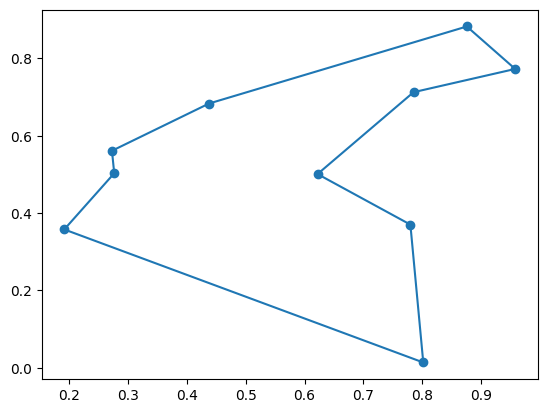

In [28]:
show_tsp(tsp, tour)

How long does it take to solve the problem 100 times?

In [29]:
%%R -i d

library("microbenchmark")

microbenchmark(tsp <- TSP(d))

Unit: microseconds
          expr     min       lq     mean  median      uq      max neval
 tsp <- TSP(d) 524.535 559.5765 587.2798 573.182 593.561 1004.738   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

Initial length: 6.04305347568933
Best length found: 2.9062078251965877
Tour length: 2.91


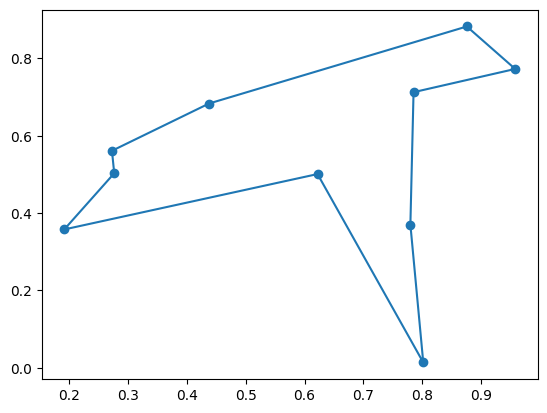

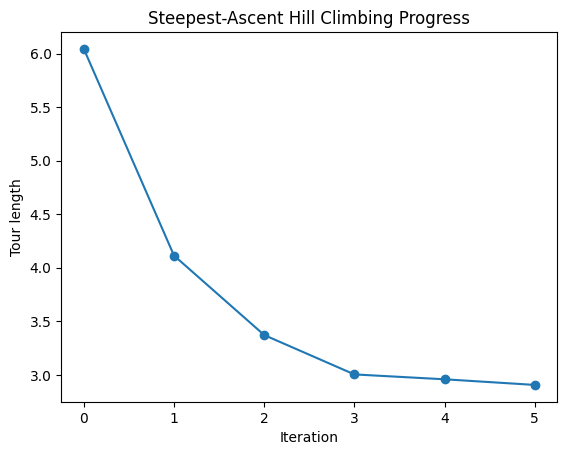

In [30]:
def all_neighbors(tour):
    """Generate all neighbors by swapping two cities"""
    neighbors = []
    for i in range(len(tour)):
        for j in range(i+1, len(tour)):
            new_tour = tour.copy()
            new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
            neighbors.append(new_tour)
    return neighbors

def steepest_ascent_hill_climb(tsp, init_tour):
    """Steepest-Ascent Hill Climbing for TSP"""
    current_tour = init_tour
    current_length = tour_length(tsp, current_tour)
    history = [current_length]

    while True:
        neighbors = all_neighbors(current_tour)
        neighbor_lengths = [tour_length(tsp, n) for n in neighbors]

        best_idx = np.argmin(neighbor_lengths)
        best_tour = neighbors[best_idx]
        best_length = neighbor_lengths[best_idx]

        if best_length >= current_length:
            break

        current_tour, current_length = best_tour, best_length
        history.append(current_length)

    return current_tour, current_length, history


init_tour = random_tour(len(tsp["dist"]))
best_tour, best_length, history = steepest_ascent_hill_climb(tsp, init_tour)

print("Initial length:", tour_length(tsp, init_tour))
print("Best length found:", best_length)

show_tsp(tsp, best_tour)

plt.plot(history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Tour length")
plt.title("Steepest-Ascent Hill Climbing Progress")
plt.show()


## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

Best tour found (length = 2.76):
[0, 7, 4, 1, 3, 8, 9, 2, 5, 6]
Tour length: 2.76


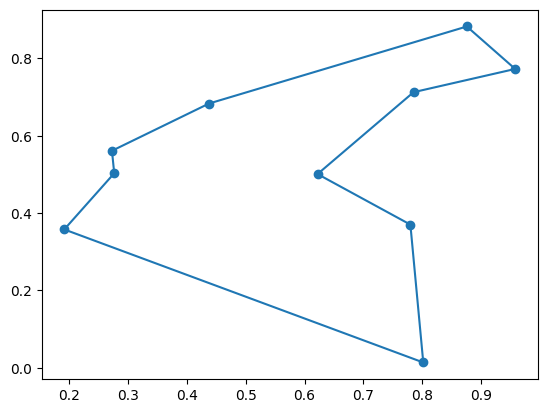

In [31]:
def best_neighbor(neighbors, tsp):
    return min(neighbors, key=lambda tour: tour_length(tsp, tour))

def hill_climb_w_restart(tsp, restarts=100):
    best_tour = None
    best_length = float("inf")
    n = len(tsp["pos"])

    for r in range(restarts):
        current_tour = random_tour(n)
        current_length = tour_length(tsp, current_tour)

        while True:
            neighbors = all_neighbors(current_tour)
            next_tour = best_neighbor(neighbors, tsp)
            next_length = tour_length(tsp, next_tour)

            if next_length < current_length:
                current_tour = next_tour
                current_length = next_length
            else:
                break

        if current_length < best_length:
            best_tour = current_tour
            best_length = current_length

    return best_tour, best_length

best_tour, best_length = hill_climb_w_restart(tsp, restarts=50)

print(f"Best tour found (length = {best_length:.2f}):")
print(best_tour)

show_tsp(tsp, best_tour)


## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

Stochastic Hill Climb result (length = 2.81):
[8, 9, 3, 2, 5, 6, 0, 7, 4, 1]
Tour length: 2.81


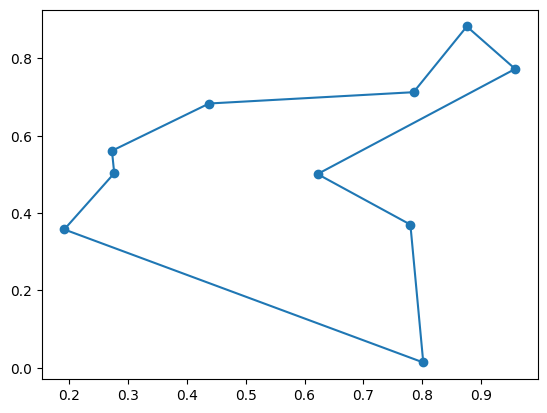

In [32]:
import random

def stochastic_hill_climb(tsp, iterations=1000):
    n = len(tsp["pos"])
    current_tour = random_tour(n)
    current_length = tour_length(tsp, current_tour)

    for _ in range(iterations):
        neighbors = all_neighbors(current_tour)
        # choose a random neighbor
        candidate = random.choice(neighbors)
        candidate_length = tour_length(tsp, candidate)

        # accept only if better
        if candidate_length < current_length:
            current_tour = candidate
            current_length = candidate_length

    return current_tour, current_length

best_tour, best_length = stochastic_hill_climb(tsp, iterations=5000)

print(f"Stochastic Hill Climb result (length = {best_length:.2f}):")
print(best_tour)

show_tsp(tsp, best_tour)


## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

In [33]:
# Code goes here

## Simulated Annealing [2 Points]

In [34]:
# Code goes here

## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [35]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.18548965454101562 milliseconds


In [36]:
# Code and results go here

## Bonus: Genetic Algorithm [+1 Point]

In [37]:
# Code goes here